# Preprocessing Data

## Missing Value

In [1]:
# 1️⃣ Import library
import os
import pandas as pd

# 2️⃣ Pastikan folder hasil ada
os.makedirs("no2_results", exist_ok=True)

# 3️⃣ Baca data hasil unduhan (raw)
file_path = "no2_results/timeseries.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ File ditemukan: {file_path}")
else:
    raise FileNotFoundError(f"❌ File tidak ditemukan di {file_path}")

# 4️⃣ Cek jumlah missing value sebelum interpolasi
missing_before = df["NO2"].isnull().sum()
print(f"\n📊 Jumlah data hilang (missing values) sebelum interpolasi: {missing_before}")

# 5️⃣ Pastikan kolom tanggal dalam format datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# 6️⃣ Lakukan interpolasi linear untuk kolom NO2
df["NO2"] = df["NO2"].interpolate(method="linear")

# 7️⃣ Hitung kembali jumlah missing setelah interpolasi
missing_after = df["NO2"].isnull().sum()
print(f"📈 Jumlah data hilang setelah interpolasi: {missing_after}")

# 8️⃣ Tampilkan ringkasan
print("\nRingkasan hasil interpolasi:")
print(f" - Total baris data : {len(df)}")
print(f" - Missing sebelum  : {missing_before}")
print(f" - Missing sesudah  : {missing_after}")
print(f" - Data berhasil dipulihkan: {missing_before - missing_after}")

# 9️⃣ Simpan hasil interpolasi ke file CSV baru
output_path = "no2_results/no2_interpolated_demak.csv"
df.to_csv(output_path, index=False)

print(f"\n✅ Data hasil interpolasi disimpan sebagai '{output_path}'")


✅ File ditemukan: no2_results/timeseries.csv

📊 Jumlah data hilang (missing values) sebelum interpolasi: 145
📈 Jumlah data hilang setelah interpolasi: 0

Ringkasan hasil interpolasi:
 - Total baris data : 395
 - Missing sebelum  : 145
 - Missing sesudah  : 0
 - Data berhasil dipulihkan: 145

✅ Data hasil interpolasi disimpan sebagai 'no2_results/no2_interpolated_demak.csv'


## Deteksi Outlier dan penanganannya

✅ File hasil interpolasi ditemukan: no2_results/no2_interpolated_demak.csv

⚠️ Ditemukan 20 outlier berdasarkan LOF.


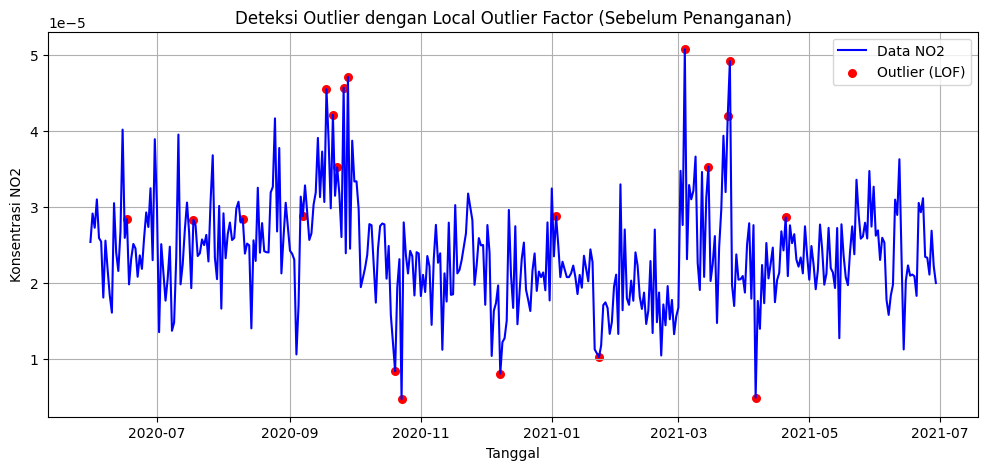

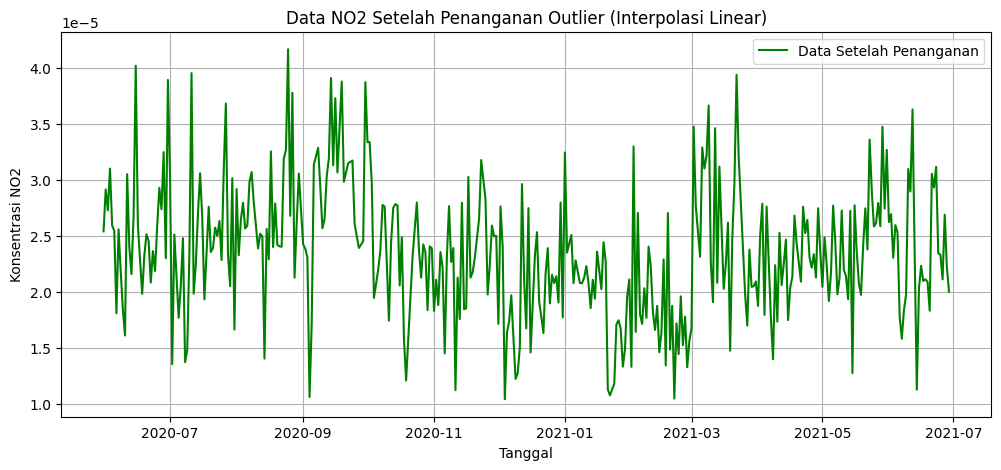


💾 Data bersih disimpan ke: no2_results/no2_cleaned_demak_lof.csv


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# 1️⃣ Baca hasil interpolasi
input_path = "no2_results/no2_interpolated_demak.csv"
output_path = "no2_results/no2_cleaned_demak_lof.csv"

if not os.path.exists(input_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {input_path}")

df = pd.read_csv(input_path)
print(f"✅ File hasil interpolasi ditemukan: {input_path}")

# Pastikan urut berdasarkan tanggal
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# 2️⃣ Terapkan LOF untuk deteksi outlier
X = df[["NO2"]].values

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # 5% diasumsikan outlier
y_pred = lof.fit_predict(X)
df["outlier"] = (y_pred == -1)

outlier_count = df["outlier"].sum()
print(f"\n⚠️ Ditemukan {outlier_count} outlier berdasarkan LOF.")

# 3️⃣ Visualisasi sebelum penanganan
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["NO2"], label="Data NO2", color="blue")
plt.scatter(df.loc[df["outlier"], "date"], df.loc[df["outlier"], "NO2"],
            color="red", label="Outlier (LOF)", s=30)
plt.title("Deteksi Outlier dengan Local Outlier Factor (Sebelum Penanganan)")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO2")
plt.legend()
plt.grid(True)
plt.show()

# 4️⃣ Tangani outlier: ubah nilai outlier menjadi NaN lalu interpolasi
df.loc[df["outlier"], "NO2"] = np.nan
df["NO2"] = df["NO2"].interpolate(method="linear")

# 5️⃣ Visualisasi setelah penanganan
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["NO2"], color="green", label="Data Setelah Penanganan")
plt.title("Data NO2 Setelah Penanganan Outlier (Interpolasi Linear)")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO2")
plt.legend()
plt.grid(True)
plt.show()

# 6️⃣ Simpan hasil
df.drop(columns=["outlier"], inplace=True)
df.to_csv(output_path, index=False)
print(f"\n💾 Data bersih disimpan ke: {output_path}")


## Membentuk Data Supervised menggunakan 2,3,4,5 Hari sebelumnya

In [7]:
# 1️⃣ Import library
import pandas as pd
import os

# 2️⃣ Pastikan folder hasil ada
os.makedirs("no2_results", exist_ok=True)

# 3️⃣ Baca data interpolasi NO2
file_path = "no2_results/no2_cleaned_demak_lof.csv"
new_df = pd.read_csv(file_path)

# 4️⃣ Pastikan urutan waktu benar
new_df = new_df.sort_values("date").reset_index(drop=True)

# 5️⃣ Hapus kolom tanggal (hanya pakai nilai NO2)
new_df = new_df.drop(columns=['date'])

# 6️⃣ Buat list untuk menyimpan hasil tiap lag
lag_list = [2, 3, 4, 5]
lag_dataframes = {}

# 7️⃣ Loop membuat data supervised untuk tiap lag
for n in lag_list:
    df_lag = new_df.copy()
    for i in range(1, n + 1):
        # Ganti nama kolom lag menjadi NO2_t-1, NO2_t-2, dst
        df_lag[f"NO2_t-{i}"] = df_lag["NO2"].shift(i)
    df_lag = df_lag.dropna().reset_index(drop=True)
    
    # Simpan ke dictionary & file
    lag_dataframes[n] = df_lag
    output_path = f"no2_results/day{n}.csv"
    df_lag.to_csv(output_path, index=False)
    print(f"✅ Data supervised dengan NO2_t-1–NO2_t-{n} disimpan di: {output_path}")

# 8️⃣ Contoh tampilkan salah satu hasil (misal lag 5)
print("\n📊 Contoh hasil day5:")
print(lag_dataframes[5].head())


✅ Data supervised dengan NO2_t-1–NO2_t-2 disimpan di: no2_results/day2.csv
✅ Data supervised dengan NO2_t-1–NO2_t-3 disimpan di: no2_results/day3.csv
✅ Data supervised dengan NO2_t-1–NO2_t-4 disimpan di: no2_results/day4.csv
✅ Data supervised dengan NO2_t-1–NO2_t-5 disimpan di: no2_results/day5.csv

📊 Contoh hasil day5:
   feature_index       NO2   NO2_t-1   NO2_t-2   NO2_t-3   NO2_t-4   NO2_t-5
0              0  0.000025  0.000026  0.000031  0.000027  0.000029  0.000025
1              0  0.000018  0.000025  0.000026  0.000031  0.000027  0.000029
2              0  0.000026  0.000018  0.000025  0.000026  0.000031  0.000027
3              0  0.000022  0.000026  0.000018  0.000025  0.000026  0.000031
4              0  0.000018  0.000022  0.000026  0.000018  0.000025  0.000026


### Memprediksi 3 hari kedepan

In [8]:
# 1️⃣ Import library
import pandas as pd
import os

# 2️⃣ Pastikan folder hasil ada
os.makedirs("no2_results", exist_ok=True)

# 3️⃣ Baca data interpolasi NO2
file_path = "no2_results/no2_cleaned_demak_lof.csv"
new_df = pd.read_csv(file_path)

# 4️⃣ Pastikan urutan waktu benar
new_df = new_df.sort_values("date").reset_index(drop=True)

# 5️⃣ Hapus kolom tanggal (hanya pakai nilai NO2)
new_df = new_df.drop(columns=['date'])

# 6️⃣ Buat list untuk menyimpan hasil tiap lag
lag_list = [2, 3, 4, 5]
lag_dataframes = {}

# 7️⃣ Loop membuat data supervised multi-step untuk tiap lag
for n in lag_list:
    df_lag = new_df.copy()
    
    # 🔹 Buat kolom lag historis (NO2_t-1, NO2_t-2, dst)
    for i in range(1, n + 1):
        df_lag[f"NO2_t-{i}"] = df_lag["NO2"].shift(i)
    
    # 🔹 Tambahkan kolom target masa depan (NO2_t+1, NO2_t+2, NO2_t+3)
    for j in range(1, 4):
        df_lag[f"NO2_t+{j}"] = df_lag["NO2"].shift(-j)
    
    # 🔹 Hapus baris kosong akibat shift
    df_lag = df_lag.dropna().reset_index(drop=True)
    
    # 🔹 Simpan ke dictionary & file
    lag_dataframes[n] = df_lag
    output_path = f"no2_results/day{n}_forecast3.csv"
    df_lag.to_csv(output_path, index=False)
    print(f"✅ Data supervised (lag {n}, forecast 3 hari) disimpan di: {output_path}")

# 8️⃣ Contoh tampilkan salah satu hasil (misal lag 5)
print("\n📊 Contoh hasil day5 (prediksi 3 hari ke depan):")
print(lag_dataframes[5].head())


✅ Data supervised (lag 2, forecast 3 hari) disimpan di: no2_results/day2_forecast3.csv
✅ Data supervised (lag 3, forecast 3 hari) disimpan di: no2_results/day3_forecast3.csv
✅ Data supervised (lag 4, forecast 3 hari) disimpan di: no2_results/day4_forecast3.csv
✅ Data supervised (lag 5, forecast 3 hari) disimpan di: no2_results/day5_forecast3.csv

📊 Contoh hasil day5 (prediksi 3 hari ke depan):
   feature_index       NO2   NO2_t-1   NO2_t-2   NO2_t-3   NO2_t-4   NO2_t-5  \
0              0  0.000025  0.000026  0.000031  0.000027  0.000029  0.000025   
1              0  0.000018  0.000025  0.000026  0.000031  0.000027  0.000029   
2              0  0.000026  0.000018  0.000025  0.000026  0.000031  0.000027   
3              0  0.000022  0.000026  0.000018  0.000025  0.000026  0.000031   
4              0  0.000018  0.000022  0.000026  0.000018  0.000025  0.000026   

    NO2_t+1   NO2_t+2   NO2_t+3  
0  0.000018  0.000026  0.000022  
1  0.000026  0.000022  0.000018  
2  0.000022  0.00001

## Pemilihan Fitur terbaik

### filter untuk prediksi satu hari


📂 Memproses: no2_results\day2.csv

🔍 Korelasi tiap lag dengan NO2:
   NO2_t-1    → korelasi = +0.4092 (40.9%) 🟢 DIPILIH
   NO2_t-2    → korelasi = +0.3407 (34.1%) 🔴 TIDAK DIPILIH

✅ Fitur terpilih (2 kolom): ['NO2', 'NO2_t-1']
❎ Fitur di-drop (1 kolom): ['NO2_t-2']
💾 Disimpan ke: no2_results\day2_selected.csv

📂 Memproses: no2_results\day3.csv

🔍 Korelasi tiap lag dengan NO2:
   NO2_t-1    → korelasi = +0.4084 (40.8%) 🟢 DIPILIH
   NO2_t-2    → korelasi = +0.3404 (34.0%) 🔴 TIDAK DIPILIH
   NO2_t-3    → korelasi = +0.2391 (23.9%) 🔴 TIDAK DIPILIH

✅ Fitur terpilih (2 kolom): ['NO2', 'NO2_t-1']
❎ Fitur di-drop (2 kolom): ['NO2_t-2', 'NO2_t-3']
💾 Disimpan ke: no2_results\day3_selected.csv

📂 Memproses: no2_results\day4.csv

🔍 Korelasi tiap lag dengan NO2:
   NO2_t-1    → korelasi = +0.4074 (40.7%) 🟢 DIPILIH
   NO2_t-2    → korelasi = +0.3384 (33.8%) 🔴 TIDAK DIPILIH
   NO2_t-3    → korelasi = +0.2386 (23.9%) 🔴 TIDAK DIPILIH
   NO2_t-4    → korelasi = +0.2272 (22.7%) 🔴 TIDAK DIPILIH

✅ Fitur

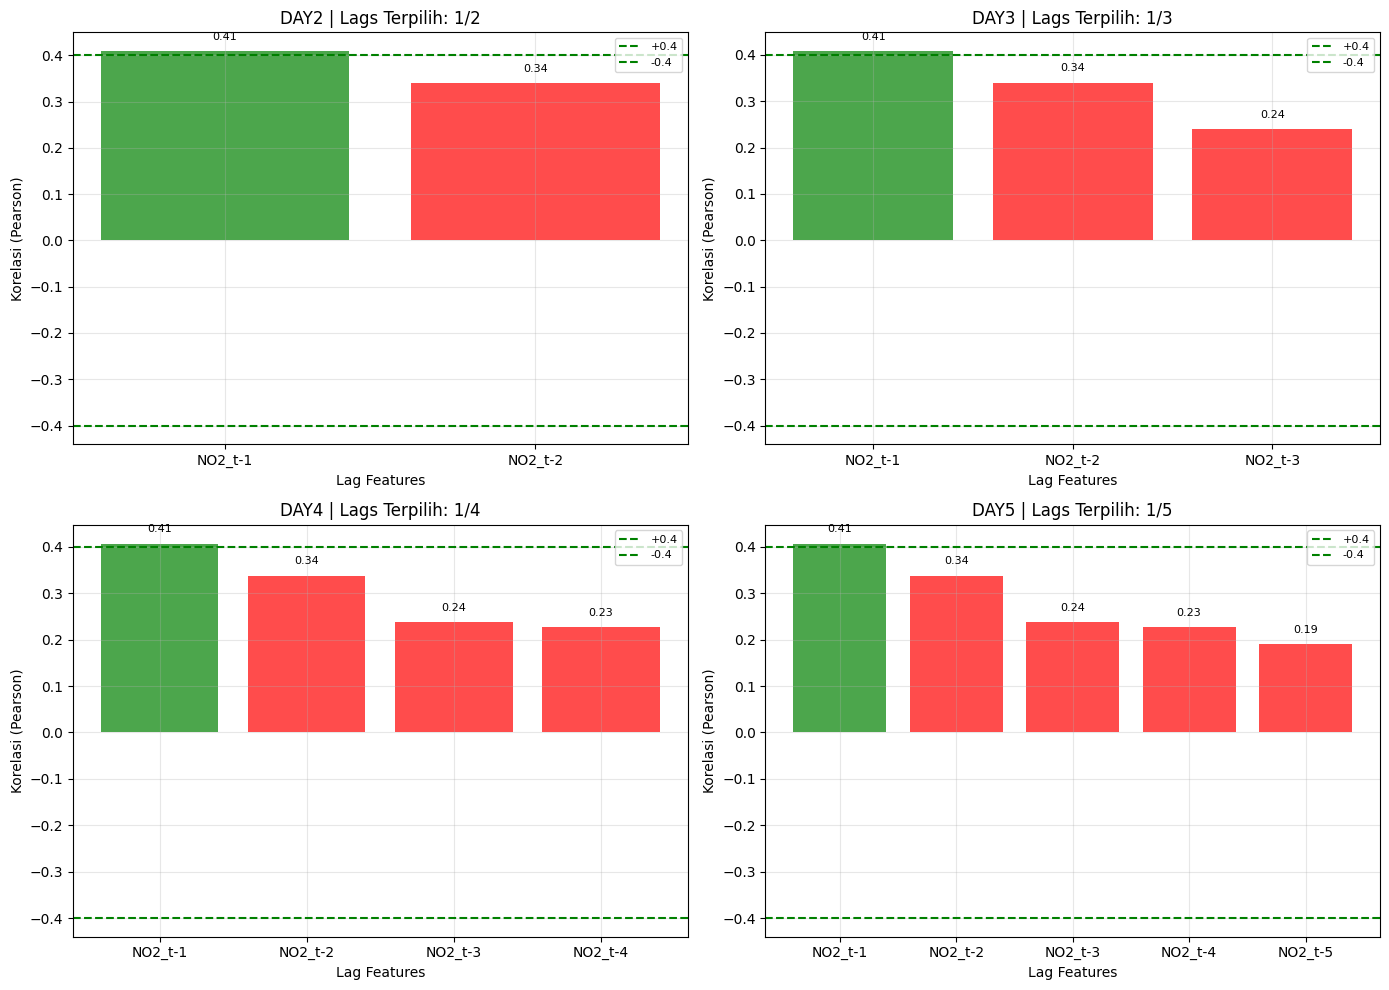

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Folder input/output
input_folder = "no2_results"
output_folder = "no2_results"
os.makedirs(output_folder, exist_ok=True)

# 2️⃣ Kolom target dan threshold
target_col = "NO2"
correlation_threshold = 0.4

# 3️⃣ Siapkan dict untuk menyimpan hasil
correlation_results = {}

# 4️⃣ Loop untuk file day2–day5 (bisa disesuaikan)
for day in [2, 3, 4, 5]:
    file_path = os.path.join(input_folder, f"day{day}.csv")

    if not os.path.exists(file_path):
        print(f"❌ File {file_path} tidak ditemukan, lewati...")
        continue

    print(f"\n📂 Memproses: {file_path}")
    df = pd.read_csv(file_path)

    # 5️⃣ Cek kolom lag (format: NO2_t-1, NO2_t-2, dst.)
    lag_cols = [col for col in df.columns if col.startswith("NO2_t-")]
    if not lag_cols:
        print(f"⚠️ Tidak ditemukan kolom lag di {file_path}")
        continue

    # 6️⃣ Hitung korelasi antar kolom lag dengan target
    correlations = {}
    selected_features = [target_col]

    print(f"\n🔍 Korelasi tiap lag dengan {target_col}:")
    for col in lag_cols:
        corr = df[target_col].corr(df[col])
        abs_corr = abs(corr)
        correlations[col] = corr

        if abs_corr >= correlation_threshold:
            selected_features.append(col)
            status = "🟢 DIPILIH"
        else:
            status = "🔴 TIDAK DIPILIH"

        print(f"   {col:<10} → korelasi = {corr:+.4f} ({abs_corr:.1%}) {status}")

    # 7️⃣ Simpan hasil ke dictionary untuk visualisasi
    correlation_results[f"day{day}"] = {
        "correlations": correlations,
        "selected_features": selected_features,
        "total_lag": len(lag_cols),
        "selected_lag": len(selected_features) - 1  # minus target
    }

    # 8️⃣ Simpan hasil seleksi ke file baru
    df_selected = df[selected_features]
    output_path = os.path.join(output_folder, f"day{day}_selected.csv")
    df_selected.to_csv(output_path, index=False)

    dropped = [col for col in lag_cols if col not in selected_features]
    print(f"\n✅ Fitur terpilih ({len(selected_features)} kolom): {selected_features}")
    print(f"❎ Fitur di-drop ({len(dropped)} kolom): {dropped}")
    print(f"💾 Disimpan ke: {output_path}")

# =====================================================
# VISUALISASI KORELASI PER DATASET
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(correlation_results.items()):
    corrs = result["correlations"]
    lags = sorted(corrs.keys(), key=lambda x: int(x.split('-')[1]))
    values = [corrs[col] for col in lags]
    colors = ['green' if abs(c) >= correlation_threshold else 'red' for c in values]

    ax = axes[idx]
    bars = ax.bar(lags, values, color=colors, alpha=0.7)

    ax.axhline(y=correlation_threshold, color='green', linestyle='--', label=f'+{correlation_threshold}')
    ax.axhline(y=-correlation_threshold, color='green', linestyle='--', label=f'-{correlation_threshold}')
    ax.set_title(f"{name.upper()} | Lags Terpilih: {result['selected_lag']}/{result['total_lag']}")
    ax.set_ylabel("Korelasi (Pearson)")
    ax.set_xlabel("Lag Features")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    # Tambahkan nilai korelasi di atas bar
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 
                height + (0.02 if height >= 0 else -0.03),
                f"{val:.2f}", ha='center', 
                va='bottom' if height >= 0 else 'top', fontsize=8)

# Hapus sumbu kosong jika dataset < jumlah subplot
for j in range(len(correlation_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### untuk yang forecasting 3 hari


📂 Memproses: no2_results\day2_forecast3.csv

🔍 Korelasi tiap lag dengan target masa depan:

📈 Target: NO2_t+1
   NO2_t-1    → korelasi = +0.3414 (34.1%) 🟢 DIPILIH
   NO2_t-2    → korelasi = +0.2386 (23.9%) 🔴 TIDAK DIPILIH

📈 Target: NO2_t+2
   NO2_t-1    → korelasi = +0.2381 (23.8%) 🔴 TIDAK DIPILIH
   NO2_t-2    → korelasi = +0.2272 (22.7%) 🔴 TIDAK DIPILIH

📈 Target: NO2_t+3
   NO2_t-1    → korelasi = +0.2269 (22.7%) 🔴 TIDAK DIPILIH
   NO2_t-2    → korelasi = +0.1907 (19.1%) 🔴 TIDAK DIPILIH

✅ Fitur terpilih (1 kolom): ['NO2_t-1']
💾 Disimpan ke: no2_results\day2_forecast3_selected.csv

📂 Memproses: no2_results\day3_forecast3.csv

🔍 Korelasi tiap lag dengan target masa depan:

📈 Target: NO2_t+1
   NO2_t-1    → korelasi = +0.3395 (33.9%) 🟢 DIPILIH
   NO2_t-2    → korelasi = +0.2381 (23.8%) 🔴 TIDAK DIPILIH
   NO2_t-3    → korelasi = +0.2272 (22.7%) 🔴 TIDAK DIPILIH

📈 Target: NO2_t+2
   NO2_t-1    → korelasi = +0.2375 (23.7%) 🔴 TIDAK DIPILIH
   NO2_t-2    → korelasi = +0.2269 (22.7%) 🔴 TI

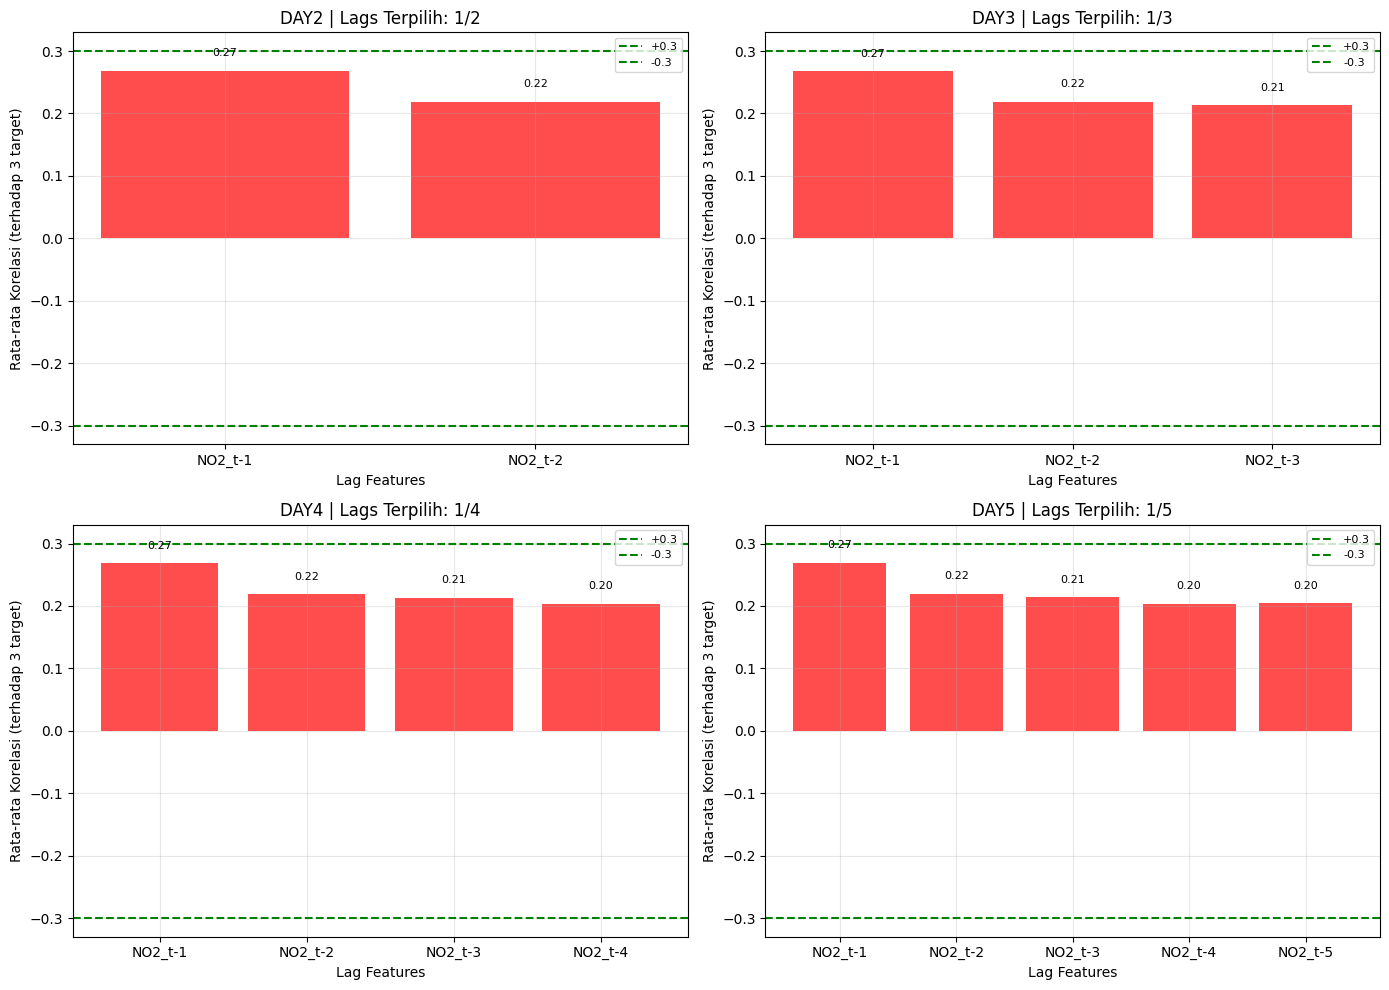

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Folder input/output
input_folder = "no2_results"
output_folder = "no2_results"
os.makedirs(output_folder, exist_ok=True)

# 2️⃣ Target & threshold
target_cols = ["NO2_t+1", "NO2_t+2", "NO2_t+3"]
correlation_threshold = 0.3

# 3️⃣ Dictionary untuk menyimpan hasil
correlation_results = {}

# 4️⃣ Loop untuk file forecasting (day2_forecast3.csv dst)
for day in [2, 3, 4, 5]:
    file_path = os.path.join(input_folder, f"day{day}_forecast3.csv")

    if not os.path.exists(file_path):
        print(f"❌ File {file_path} tidak ditemukan, lewati...")
        continue

    print(f"\n📂 Memproses: {file_path}")
    df = pd.read_csv(file_path)

    # 5️⃣ Cek kolom lag dan target
    lag_cols = [col for col in df.columns if col.startswith("NO2_t-")]
    available_targets = [col for col in target_cols if col in df.columns]

    if not lag_cols or not available_targets:
        print(f"⚠️ Kolom lag atau target tidak ditemukan di {file_path}")
        continue

    # 6️⃣ Hitung korelasi lag terhadap tiap target
    correlations = {}
    selected_features = set()

    print(f"\n🔍 Korelasi tiap lag dengan target masa depan:")
    for target in available_targets:
        print(f"\n📈 Target: {target}")
        for lag in lag_cols:
            corr = df[target].corr(df[lag])
            abs_corr = abs(corr)
            correlations[(target, lag)] = corr

            if abs_corr >= correlation_threshold:
                selected_features.add(lag)
                status = "🟢 DIPILIH"
            else:
                status = "🔴 TIDAK DIPILIH"

            print(f"   {lag:<10} → korelasi = {corr:+.4f} ({abs_corr:.1%}) {status}")

    # 7️⃣ Simpan hasil seleksi
    selected_features = sorted(list(selected_features))
    df_selected = df[selected_features + available_targets]

    output_path = os.path.join(output_folder, f"day{day}_forecast3_selected.csv")
    df_selected.to_csv(output_path, index=False)

    correlation_results[f"day{day}"] = {
        "correlations": correlations,
        "selected_features": selected_features,
        "total_lag": len(lag_cols),
        "selected_lag": len(selected_features),
    }

    print(f"\n✅ Fitur terpilih ({len(selected_features)} kolom): {selected_features}")
    print(f"💾 Disimpan ke: {output_path}")

# =====================================================
# VISUALISASI KORELASI PER DATASET
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(correlation_results.items()):
    corrs = result["correlations"]
    
    # Hitung rata-rata korelasi per lag (terhadap semua target)
    lag_to_corr = {}
    for (target, lag), value in corrs.items():
        lag_to_corr.setdefault(lag, []).append(value)
    avg_corr = {lag: sum(vals)/len(vals) for lag, vals in lag_to_corr.items()}

    # Siapkan data untuk plot
    lags = sorted(avg_corr.keys(), key=lambda x: int(x.split('-')[1]))
    values = [avg_corr[lag] for lag in lags]
    colors = ['green' if abs(v) >= correlation_threshold else 'red' for v in values]

    ax = axes[idx]
    bars = ax.bar(lags, values, color=colors, alpha=0.7)

    ax.axhline(y=correlation_threshold, color='green', linestyle='--', label=f'+{correlation_threshold}')
    ax.axhline(y=-correlation_threshold, color='green', linestyle='--', label=f'-{correlation_threshold}')
    ax.set_title(f"{name.upper()} | Lags Terpilih: {result['selected_lag']}/{result['total_lag']}")
    ax.set_ylabel("Rata-rata Korelasi (terhadap 3 target)")
    ax.set_xlabel("Lag Features")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 
                height + (0.02 if height >= 0 else -0.03),
                f"{val:.2f}", ha='center', 
                va='bottom' if height >= 0 else 'top', fontsize=8)

# Hapus subplot kosong jika dataset < jumlah plot
for j in range(len(correlation_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
